## Bike Sharing Demand Project
2022.05.25 start - 2022.06.09 end (2 weeks)
### 프로젝트 목표
1. train data를 바탕으로 사용패턴을 파악한다. (현황파악) 궁금한 질문들을 만들어보고 이를 알아본다!
2. 위의 패턴을 바탕으로 적절한 모델을 설정, 전처리 + 모델링을 통해 test data에 대해 예측한다.  

**`목표`: 날씨 데이터를 바탕으로 Bike rental demand를 예측하기**

---
## EDA notebook
목차  
1. Load the data
    1. EDA 전 점검
2. EDA train data
    1. continuous variable(연속형 변수)와 대여량 간 관계
    2. categorical variable(카테고리형 변수)와 대여량 간 관계
    3. 3개 변수 간 관계 파악

## 1. Load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#train data : target은 count 컬럼 
train = pd.read_csv('data/train.csv')
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# test data
test = pd.read_csv('data/test.csv')
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## 1-1. EDA 전, 데이터 점검
### 중복 체크 -> ok!

In [4]:
sum(train.duplicated())

0

In [5]:
sum(test.duplicated())

0

### 결측치 체크 -> ok!

In [6]:
# 결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [8]:
test.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## 2. EDA train data
여러 질문을 생각해보고 이를 풀어내자

- 날씨와 대여량 간에 상관관계가 크지 않을까? 어떤 컬럼이 가장 상관성이 큰지 궁금! 날씨, 온도, 습도, 풍향 등
    - 덧붙여서 상관성이 총대여량(count) 외에도 casual, registered랑 관련있는지도 궁금하다
- 보통은 날씨가 좋아야 대여를 할 거 같은데.. 이게 1~4 당 count 수가 몇일까? 1, 2, 3, 4 어떤 상태일 때 count가 가장 클까?(개인적으론 화창할 때에만 타고 싶을거 같다.. 비오고 이러면 불편하니까)
    - 그리고 어떤 시간(월, 일)에 가장 날씨가 좋았는지 / 아님 시간당 대여량은?
- 쉬는날과 일하는날에 대여량이 큰 차이가 날까?
    - 그리고 쉬는날과 일하는 날엔 빌린 시간 (hour)이 좀 차이가 날거같아..!! 어차피 지역은 하나니까. 쉬는날엔 오후에, 평일엔 아침이나 저녁에 높지않을까?
- 시간대별로 온도와 체감온도가 많이 차이가 날까?

In [9]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
# 우선은 datetime 컬럼을 시간으로 쪼개보자
train['datetime2'] = pd.to_datetime(train['datetime'])
train.dtypes

datetime              object
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
datetime2     datetime64[ns]
dtype: object

In [11]:
train['year'] = train['datetime2'].dt.year
train['month'] = train['datetime2'].dt.month
train['day'] = train['datetime2'].dt.day
train['hour'] = train['datetime2'].dt.hour
#분, 초는 활용 불가. hour 단위로 되어있기 때문에
# train['minute'] = train['datetime2'].dt.minute
# train['second'] = train['datetime2'].dt.second
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime2,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,1,1,4


#### count 중에 casual과 registered 중 어떤 것의비율이 클까?
- registered가 8, casual이 2

In [12]:
print('Casual의 비율: ', round((train['casual'].sum() / train['count'].sum())*100, 2))
print('Registered의 비율: ', round((train['registered'].sum() / train['count'].sum())*100, 2))

Casual의 비율:  18.8
Registered의 비율:  81.2


#### season에 해당하는 month

In [13]:
train.groupby(['season', 'month'])[['month']].count()

month
season month       
1      1        884
       2        901
       3        901
2      4        909
       5        912
       6        912
3      7        912
       8        912
       9        909
4      10       911
       11       911
       12       912

실제로 봄이 3,4,5월이지만 여기선 1,2,3월을 봄(season 1)으로 정의하였음.  
그래서 season은 봄, 여름, 가을, 겨울로 구분하지 않고,  
**1분기 / 2분기 / 3분기 / 4분기**로 구분한다.

### Q1. 연속형 변수(온도, 체감온도, 습도, 풍향)과 target(대여량) 간 상관관계 파악
어떤 컬럼이 가장 상관성이 큰지 궁금

In [14]:
train[['weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,weather,temp,atemp,humidity,windspeed,count
weather,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


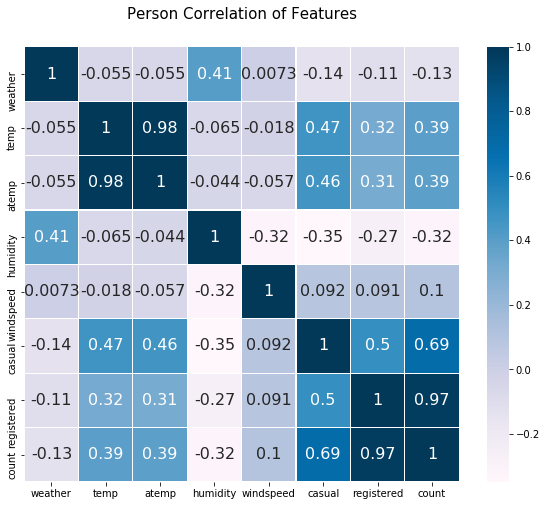

In [15]:
colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(train[['weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr(), linewidths = 0.1, vmax = 1.0 ,
            square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

count(대여량)과 가장 큰 상관이 있는 것은 날씨가 아닌 **온도** 였다. (아무래도 날씨(weather)컬럼은 카테고리형으로 되어있어서 나눠봐야할듯..)  
암튼 온도/체감온도 상관성은 0.39로 높은 편 > 습도도 -0.32로 높은편이었다(반비례) > 날씨와 풍속은 0.1수준이었음.

**registered보다는 causal이 좀더 다른 변수들과 상관성이 있는 것**으로 나왔다. 데이터 개수는 registered가 훨씬 많은데..  
왜그런걸까? `사람들이 예약을 안했더라도 날씨 괜찮으면 즉석에서 빌리는 걸 더 좋아하는것 아닐까!!` 하고 생각해본다.  
아무튼 registered와 변수들과의 관계는 count와 변수들간 관계랑 비슷하게 나온듯.

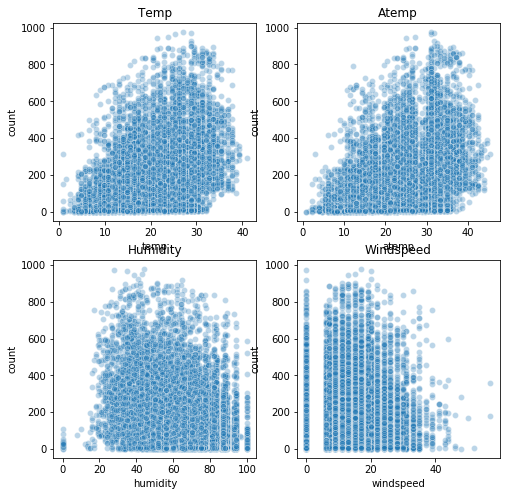

In [16]:
# count와 다른 연속형 변수들 간 산점도 그리기 
fig, axs = plt.subplots(2,2, figsize=(8, 8))
ax1, ax2, ax3, ax4 = axs.flatten()

axs1 = sns.scatterplot('temp', 'count', data = train, ax = ax1, alpha = 0.3)
axs2 = sns.scatterplot('atemp', 'count', data = train, ax = ax2, alpha = 0.3)
axs3 = sns.scatterplot('humidity', 'count', data = train, ax = ax3, alpha = 0.3)
axs4 = sns.scatterplot('windspeed', 'count', data = train, ax = ax4, alpha = 0.3)

axs1.set_title('Temp')
axs2.set_title('Atemp')
axs3.set_title('Humidity')
axs4.set_title('Windspeed')

plt.show()


연속형 변수들과 count 간 산점도를 간단히 그렸다.  
- temp, atemp는 상관계수 약 0.4로 약간의 정비례 관계가 보이고, 
- humidity는 -0.3으로 약간의 반비례,
- windspeed는 0.1정도라 경향성이 안보인다.. 

사실 어떻게 봐도 경향성이 잘 보인다고 볼 순 없을거 같다..^-^ 사실 데이터가 한번에 target과 인과성이 바로 나타나는 건 드무니까!!  
그래서 제3의 기준을 더 추가해서 그래프를 좀 나눠볼 필요성이 있어보임 -> Q3에서

#### casual, registered, count의 분포

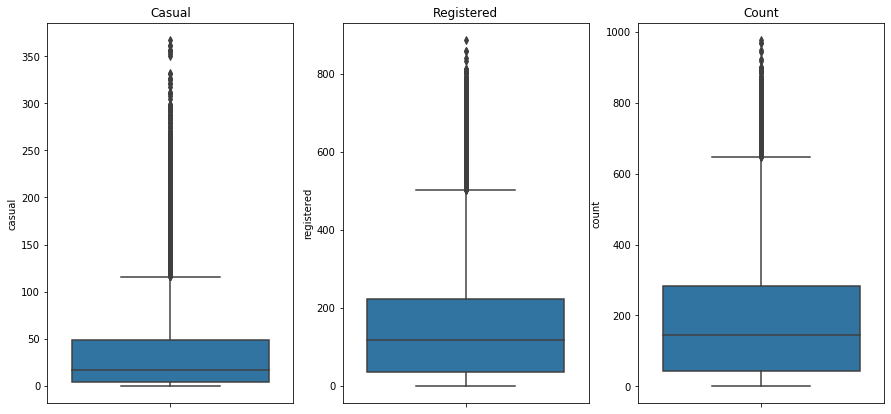

In [17]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7))

sns.boxplot(y = 'casual', data = train, ax = ax1)
sns.boxplot(y = 'registered', data = train, ax = ax2)
sns.boxplot(y = 'count', data = train, ax = ax3)

ax1.set_title('Casual')
ax2.set_title('Registered')
ax3.set_title('Count')

plt.show()

### Q2. 카테고리형 변수와 target 간 관계
- 시간(year, month, day, hour)
- 날씨(weather) 
- 분기(season)
- 평일,주말(workingday), 휴일(holiday)   
---
*여기서는 그냥 변수와 타겟(대여량) 간 관계만 보고, 의미있는 카테고리형 변수라면 3개 변수 이상 묶을 때 기준으로 쓰기 -> Q3에서*

### 1) year, month, day, hour와 평균 count 간 관계

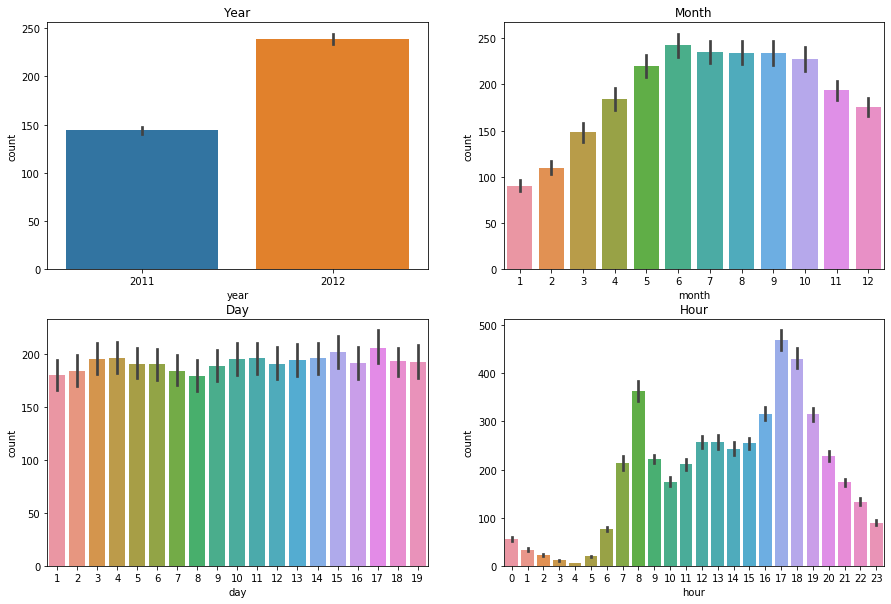

In [18]:
fig, axs = plt.subplots(2,2, figsize=(15, 10))
ax1, ax2, ax3, ax4 = axs.flatten()

#y축은 평균 대여량
axs1 = sns.barplot('year', 'count', data=train, ax = ax1)
axs2 = sns.barplot('month', 'count', data=train, ax = ax2)
axs3 = sns.barplot('day', 'count', data=train, ax = ax3)
axs4 = sns.barplot('hour', 'count', data=train, ax = ax4)

axs1.set_title('Year')
axs2.set_title('Month')
axs3.set_title('Day')
axs4.set_title('Hour')

plt.show()

<해석>   
- year: 2011년에 비해 2012년 평균 대여량 많아짐
- month: 가장 평균 대여량이 많은 것은 6월. **5,6,7,8,9,10월 모두 평균 대여량 높다** (즉, 여름&가을 이용량 많음)
- day: 큰 차이를 보이지 않음 / *게다가 train set은 날짜가 1일~19일까지만 있고, test set엔 20일 이후가 있으므로 피처화 불가능*
- hour: 자주 이용하는 시간대가 뚜렷. **특히 오전 8시 & 오후 5시-6시** 대여량이 높다

### 2) weather와 평균 대여량 간 관계
- weather변수의 값 소개
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

In [19]:
#주어진 데이터에서 날씨별로 데이터가 얼마나 있나?
(train.groupby('weather')[['datetime']].count() / len(train))*100

,datetime
weather,
1,66.066507
2,26.033437
3,7.890869
4,0.009186


- 주어진 데이터가 좀 편파적인 데이터임을 감안하자..! 1인 게 66%, 2인 게 26%로 전반적으로 날씨가 좋은 도시이다.

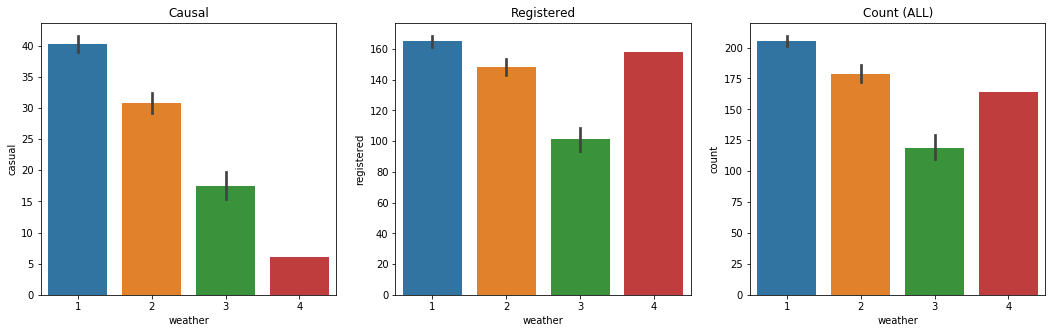

In [20]:
fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()

#y축은 "평균" 대여량 
axs1 = sns.barplot('weather', 'casual', data=train, ax = ax1)
axs2 = sns.barplot('weather', 'registered', data=train, ax = ax2)
axs3 = sns.barplot('weather', 'count', data=train, ax = ax3)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

`날씨가 안좋은 날(날씨값이 3,4)은 일수는 적지만, 그렇다고 대여를 안 하는 건 아니다.` (오히려 날씨가 4여도 약 170건의 대여가 있었다는 거..!!)  

### 3) season (분기)
- season 변수 값 소개
    - 1 = spring, 2 = summer, 3 = fall, 4 = winter 로 나와 있지만
    - 실제로는 1,2,3월이 1 / 4,5,6월이 2 이렇게 나와 있어서 `1분기 / 2분기 / 3분기 / 4분기`로 봐야한다.

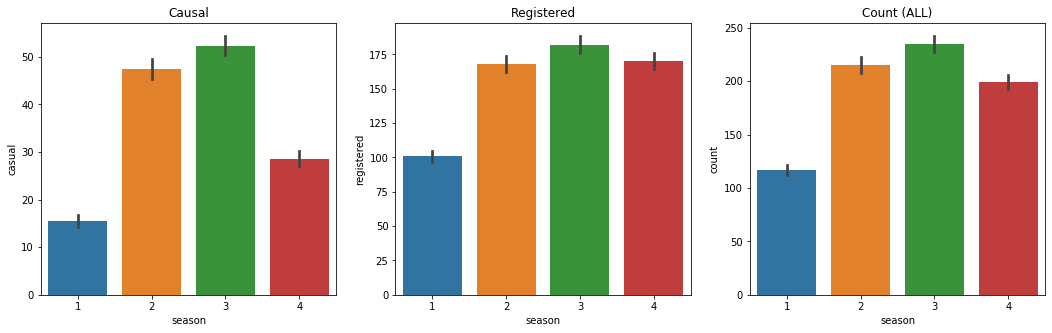

In [21]:
# 이번엔 season과 예약건수를 비교해보자. 
fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()

axs1 = sns.barplot('season', 'casual', data=train, ax = ax1)
axs2 = sns.barplot('season', 'registered', data=train, ax = ax2)
axs3 = sns.barplot('season', 'count', data=train, ax = ax3)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

- 예상대로 `2분기, 3분기(즉, 늦봄~초가을)`에 가장 많이 탄다.
- registered와 casual은 다른 양상이다.
    - 여기서도 예약을 했으니까 봄,겨울에 춥더라도 타겠다,, 는 의지가 보인다.

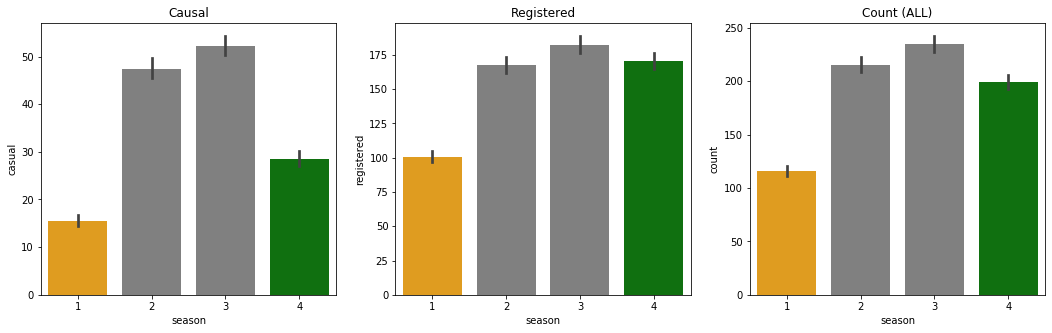

In [22]:
# 1,4사분기 포커스
fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()
col = ['orange', 'grey', 'grey', 'green']

axs1 = sns.barplot('season', 'casual', data=train, ax = ax1, palette = col)
axs2 = sns.barplot('season', 'registered', data=train, ax = ax2,  palette = col)
axs3 = sns.barplot('season', 'count', data=train, ax = ax3, palette = col)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

### 4) workingday, holiday
쉬는날과 일하는날에 대여량이 큰 차이가 날까?  
쉬는날과 일하는 날엔 빌린 시간 (hour)이 좀 차이가 날거같아..!! 어차피 지역은 워싱턴 D.C. 하나니까.  
쉬는날엔 오후에, 평일엔 아침이나 저녁에 높지않을까?

In [23]:
# 홀리데이/워킹데이일 때와 이용횟수 간 관계를 알아보자.
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime2,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,1,1,4


- 여기서 주의점
    - holiday: 공휴일. (주말X)
    - workingday: 공휴일과 주말 모두 아닌 날.
- 그래서 holiday : workingday가
    - 1 이면 공휴일
    - 0 : 1 이면 평일
    - 0: 0 이면 주말

In [24]:
# 새로운 컬럼 생성 
train['day_type'] = 'weekend'
is_holi = (train['holiday'] == 1)
is_week = (train['workingday'] == 1)

train.loc[(is_holi), 'day_type'] = 'holiday'
train.loc[(is_week), 'day_type'] = 'workingday'
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime2,year,month,day,hour,day_type
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,1,1,0,weekend
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,1,1,1,weekend
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,1,1,2,weekend
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,1,1,3,weekend
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,1,1,4,weekend


In [25]:
train.groupby('day_type')[['casual', 'registered', 'count']].sum()

,casual,registered,count
day_type,,,
holiday,15171,42637,57808
weekend,190866,406198,597064
workingday,186098,1244506,1430604


In [26]:
# 위의 결과만 보면 공휴일이 가장 적어보이는데, 이는 공휴일의 수가 가장 적어서인 듯?
## 주말, 평일, 공휴일의 날짜 수를 세어 나눠주자.
work_holi  =(train.groupby('day_type')[['casual', 'registered', 'count']].sum()/ train.groupby('day_type')[['casual', 'registered', 'count']].count())
work_holi

,casual,registered,count
day_type,,,
holiday,48.781350,137.096463,185.877814
weekend,60.343345,128.421752,188.765096
workingday,25.107663,167.904209,193.011873


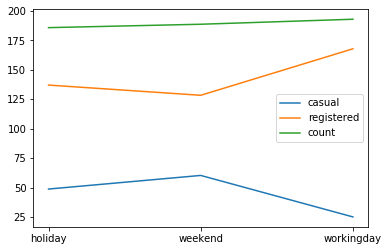

In [27]:
#시각화 
plt.plot(work_holi)
plt.legend(work_holi.columns)
plt.show()

위의 그래프를 보자.  
전체적으로, 예약대여 > 즉석대여 였음.   

- casual: 즉석 대여하는 경우는 당연히 평일이 가장 적었다. `주말 > 공휴일 > 평일` 순
- registered: 미리 예약해 대여하는 경우는 평일이 가장 많았다! `평일 > 공휴일 > 주말` 순
- 전체적으로: `평일>주말>공휴일` 순.. 하지만 크게 차이는 안 남.  
-> 즉, 평일/주말/공휴일 모두 비슷한 비율로 자전거를 타는데, **평일엔 주로 예약을 해서 타고, 주말엔 즉석대여가 많았다는 것! 하지만 세개 모두 즉석대여보단 예약으로 이용하는 경우가 많음**

#### 그래서 생각난 재밌는 것 -> 타는 시간대(hour)가 평일/주말/공휴일 간에 차이가 크게 날 것 같다. 알아보자!!
- maybe..내 생각엔 평일은 출퇴근이나 통학용으로 쓰지않을까 싶어서 이 시간대(아침/저녁)에 몰리지 않을까
- 주말이나 공휴일은 낮시간에 많을거 같음

In [28]:
# 데이터 나누기
h1 = train.loc[train['day_type'] == 'workingday']
h2 = train.loc[train['day_type'] == 'weekend']
h3 = train.loc[train['day_type'] == 'holiday']

print(len(h1), len(h2), len(h3))

7412 3163 311


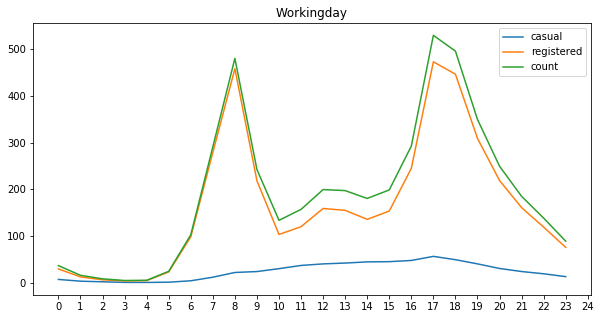

In [29]:
# 평일에 대해 - 시간대별 평균대여량 
h1_df = h1.groupby('hour')[['casual', 'registered', 'count']].mean()
plt.figure(figsize = (10,5))
plt.plot(h1_df)
plt.xticks(np.arange(0, 25))
plt.legend(h1_df.columns)
plt.title('Workingday')
plt.show()

**평일은 보통 예약을 하여 이용한다고 했으므로**, 위와 같은 그래프 형태가 나왔다.  
예약을 많이 한 시간은 내 예상대로 `오전 6시부터 증가하기 시작 - 오전 8시 피크 후 내려가는 형태` & `오후 4시부터 증가 시작 - 오후 5~6시 피크 후 내려가는 형태` 이다.  
즉석이용의 경우 오후 5시가 그나마 많았다.

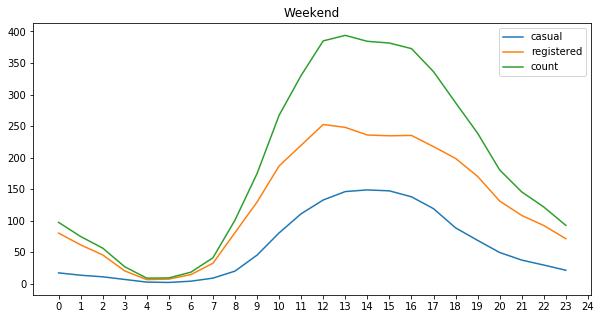

In [30]:
# 주말에 대해 - 시간대별 평균대여량 
h2_df = h2.groupby('hour')[['casual', 'registered', 'count']].mean()
plt.figure(figsize = (10,5))
plt.plot(h2_df)
plt.xticks(np.arange(0, 25))
plt.legend(h2_df.columns)
plt.title('Weekend')
plt.show()

**주말은 평일에 비해선 즉석대여가 많은편** 이었다.  
특히 내 예상대로 낮 시간대 이용이 두드러진다. `오전7시부터 증가하기 시작 - 오후 12시~4시 사이에 피크를 찍고 감소`하는 형태이다.  
특이한 점은 **예약하는 케이스나 즉석이용하는 케이스나 몰리는 시간대는 따로 있었다**는 점. 그리고 주말이라 그런지 밤 12시에 예약자도 좀 있네..?많진 않지만.

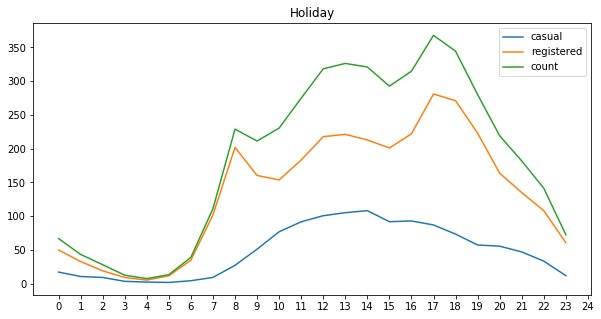

In [31]:
# 공휴일에 대해 - 시간대별 평균대여량 
h3_df = h3.groupby('hour')[['casual', 'registered', 'count']].mean()
plt.figure(figsize = (10,5))
plt.plot(h3_df)
plt.xticks(np.arange(0, 25))
plt.legend(h3_df.columns)
plt.title('Holiday')
plt.show()

공휴일도 **즉석대여가 꽤 있는 편** 이다. 그런데 특이하게도, **예약과 즉석대여 케이스에 따라 피크 시간이 달랐다!**  

- 즉석대여의 경우 `오전7시부터 증가 - 오전10시~오후3시까지 피크 후 완만한 감소`
- 예약의 경우 `오전8시, 오후12시-1시, 오후 5시-6시`가 피크였다. 또한 오후 5시-6시가 가장 이용이 많았음

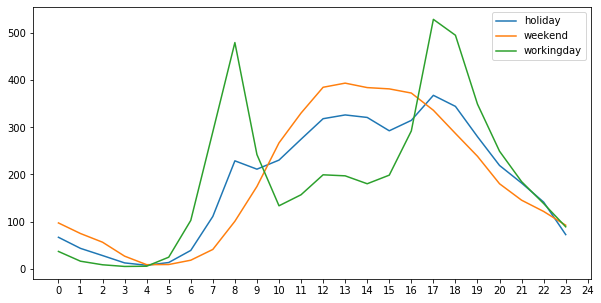

In [32]:
# 평일 / 주말/ 공휴일 그래프를 한번에 그리면 더 돋보인다
h_all  = train.pivot_table(index = 'hour', columns = 'day_type', values = 'count', aggfunc = 'mean')
plt.figure(figsize = (10, 5))
plt.plot(h_all)
plt.legend(h_all.columns)
plt.xticks(np.arange(0, 25))
plt.show()

- 평일: 출퇴근 시간인 오전8시 & 오후 5-6시 완전 몰림
- 주말&공휴일: 낮 시간에 대다수 이용
    - 주말이 좀더 평균이용수 많으며, 오후 12시~4시 사이에 급 피크 -> 특히 완전 낮 시간
    - 공휴일은 오전8시부터 오후 6-7시까지 높음, 좀더 범위가 넓은 편 -> 특히 저녁 5-6시

#### 그렇다면, 이런 평일/주말/공휴일 변수는 hour 외에 다른 변수와도 count(대여량)에 특이사항을 보이는지 알아보자!!
- 1) 계절

In [33]:
# 평일 
h1_c = h1.groupby('season')[['count']].mean().reset_index()
h1_ca = h1.groupby('season')[['casual']].mean().reset_index()
h1_re = h1.groupby('season')[['registered']].mean().reset_index()

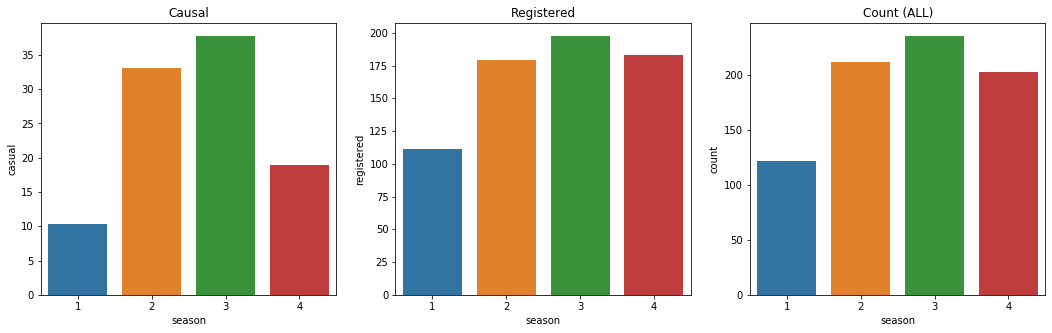

In [34]:
fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()

axs1 = sns.barplot('season', 'casual', data=h1_ca, ax = ax1)
axs2 = sns.barplot('season', 'registered', data=h1_re, ax = ax2)
axs3 = sns.barplot('season', 'count', data=h1_c, ax = ax3)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

평일은 전체 데이터 중 다수를 차지하기 때문에, Q2에서 전체적으로 그렸던 그래프와 똑같게 나온다.

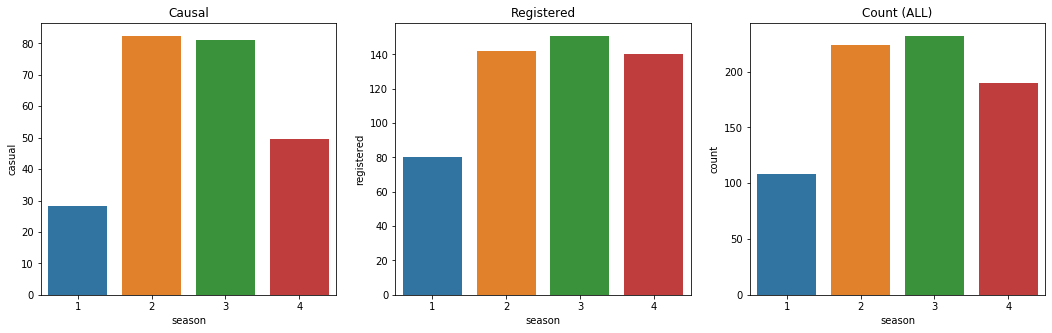

In [35]:
# 주말
h2_c = h2.groupby('season')[['count']].mean().reset_index()
h2_ca = h2.groupby('season')[['casual']].mean().reset_index()
h2_re = h2.groupby('season')[['registered']].mean().reset_index()

fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()

axs1 = sns.barplot('season', 'casual', data=h2_ca, ax = ax1)
axs2 = sns.barplot('season', 'registered', data=h2_re, ax = ax2)
axs3 = sns.barplot('season', 'count', data=h2_c, ax = ax3)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

주말도 똑같이 나온다,,

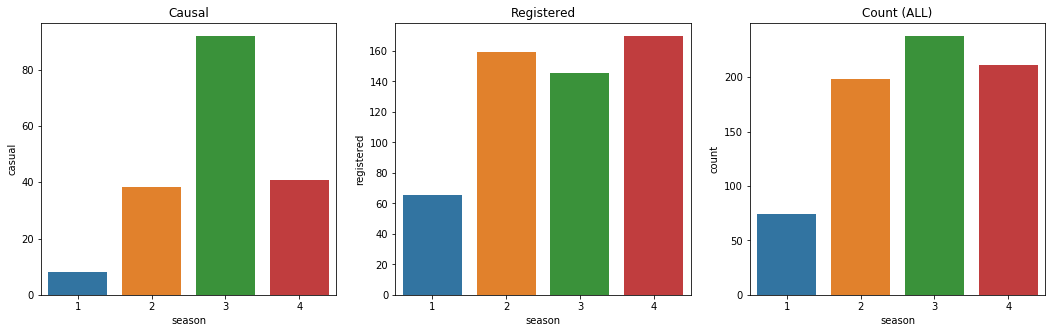

In [36]:
# 공휴일 
h3_c = h3.groupby('season')[['count']].mean().reset_index()
h3_ca = h3.groupby('season')[['casual']].mean().reset_index()
h3_re = h3.groupby('season')[['registered']].mean().reset_index()

fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()

axs1 = sns.barplot('season', 'casual', data=h3_ca, ax = ax1)
axs2 = sns.barplot('season', 'registered', data=h3_re, ax = ax2)
axs3 = sns.barplot('season', 'count', data=h3_c, ax = ax3)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

공휴일(holiday)의 경우엔 season에 따라 봤을 때 전체적인 그래프와 살짝 차이가 있다.  
특히, casual에서! **여름**에는 별로 이용을 안하는데 또 예약은 여름이 많다.   
-> holiday, workingday 변수로써 계절에 따른 대여량을 다르게 나타낼 수 있을 거 같다는 생각!

- 2) weather

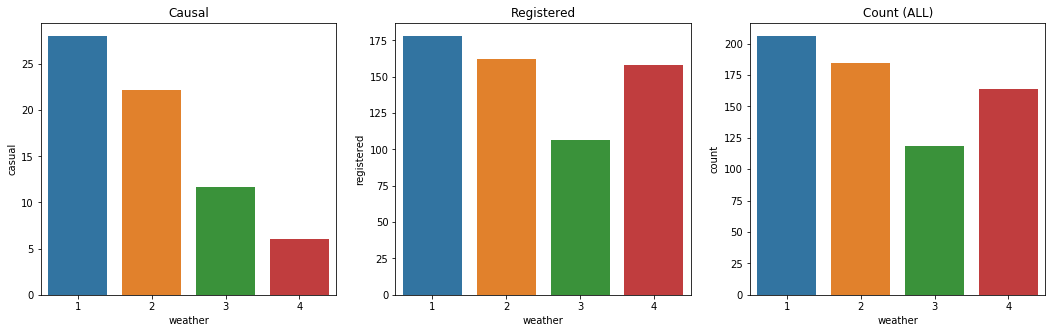

In [38]:
# 평일 
h1_c = h1.groupby('weather')[['count']].mean().reset_index()
h1_ca = h1.groupby('weather')[['casual']].mean().reset_index()
h1_re = h1.groupby('weather')[['registered']].mean().reset_index()

fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()

axs1 = sns.barplot('weather', 'casual', data=h1_ca, ax = ax1)
axs2 = sns.barplot('weather', 'registered', data=h1_re, ax = ax2)
axs3 = sns.barplot('weather', 'count', data=h1_c, ax = ax3)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

역시 평일은 위에서 그렸던 전체적인 현황과 비슷하게 나오고 있다. 날씨가 안 좋아도, (특히 예약을 한 경우라면) 자전거를 타고 있다.

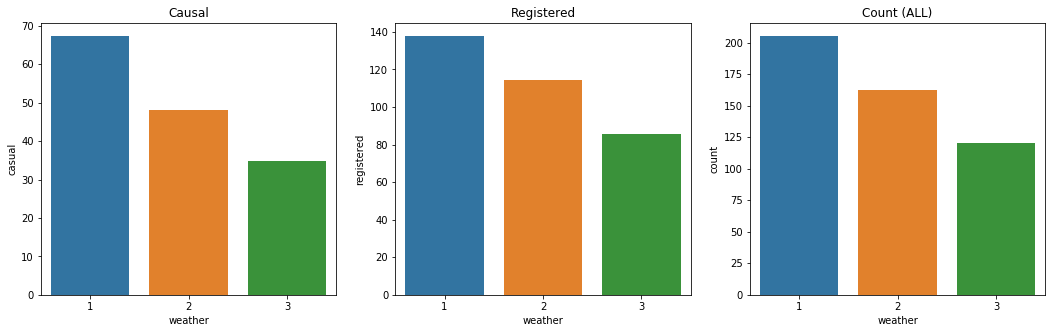

In [39]:
# 주말
h2_c = h2.groupby('weather')[['count']].mean().reset_index()
h2_ca = h2.groupby('weather')[['casual']].mean().reset_index()
h2_re = h2.groupby('weather')[['registered']].mean().reset_index()

fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()

axs1 = sns.barplot('weather', 'casual', data=h2_ca, ax = ax1)
axs2 = sns.barplot('weather', 'registered', data=h2_re, ax = ax2)
axs3 = sns.barplot('weather', 'count', data=h2_c, ax = ax3)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

주말은 날이 가장 안 좋은 날(4)의 이용은 없었다.  
그리고 평일과 비슷한 경향을 보인다. 날씨가 안좋다고 아예 안 타는 건 아니지만, 그래도 날씨가 좋을수록 평균 이용량은 비례한다.

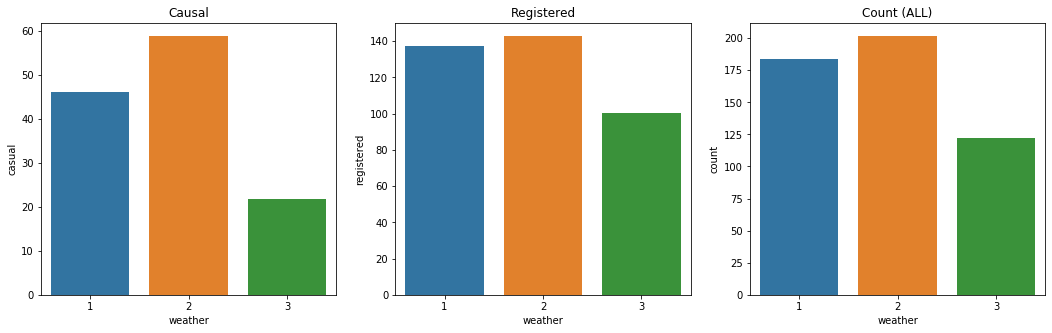

In [40]:
# 공휴일 
h3_c = h3.groupby('weather')[['count']].mean().reset_index()
h3_ca = h3.groupby('weather')[['casual']].mean().reset_index()
h3_re = h3.groupby('weather')[['registered']].mean().reset_index()

fig, axs = plt.subplots(1,3, figsize=(18,5))
ax1, ax2, ax3 = axs.flatten()

axs1 = sns.barplot('weather', 'casual', data=h3_ca, ax = ax1)
axs2 = sns.barplot('weather', 'registered', data=h3_re, ax = ax2)
axs3 = sns.barplot('weather', 'count', data=h3_c, ax = ax3)

axs1.set_title('Causal')
axs2.set_title('Registered')
axs3.set_title('Count (ALL)')

plt.show()

공휴일은 좀 달랐다..!  
casual의 경우, 날씨가 1보다 2일 때 평균이용량이 더 높았다 (오잉?!)  
왜일까? 보니까 weather가 2인 게 1인 것보다 많은 것도 아닌데.. 특이하다.. 

### Q3. 3개 이상 변수 간의 관계 파악하기
### 1) hour별 평균 대여량

In [43]:
#datetime으로부터 요일 추출하기 (dayofweek 활용)
train['dayofweek'] = train['datetime2'].dt.dayofweek
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime2,year,month,day,hour,day_type,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,1,1,0,weekend,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,1,1,1,weekend,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,1,1,2,weekend,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,1,1,3,weekend,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,1,1,4,weekend,5


dayofweek  
- 0: monday ~ 6: sunday

In [44]:
train['dayofweek'].value_counts() #요일별 수는 큰 차이 없음 

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

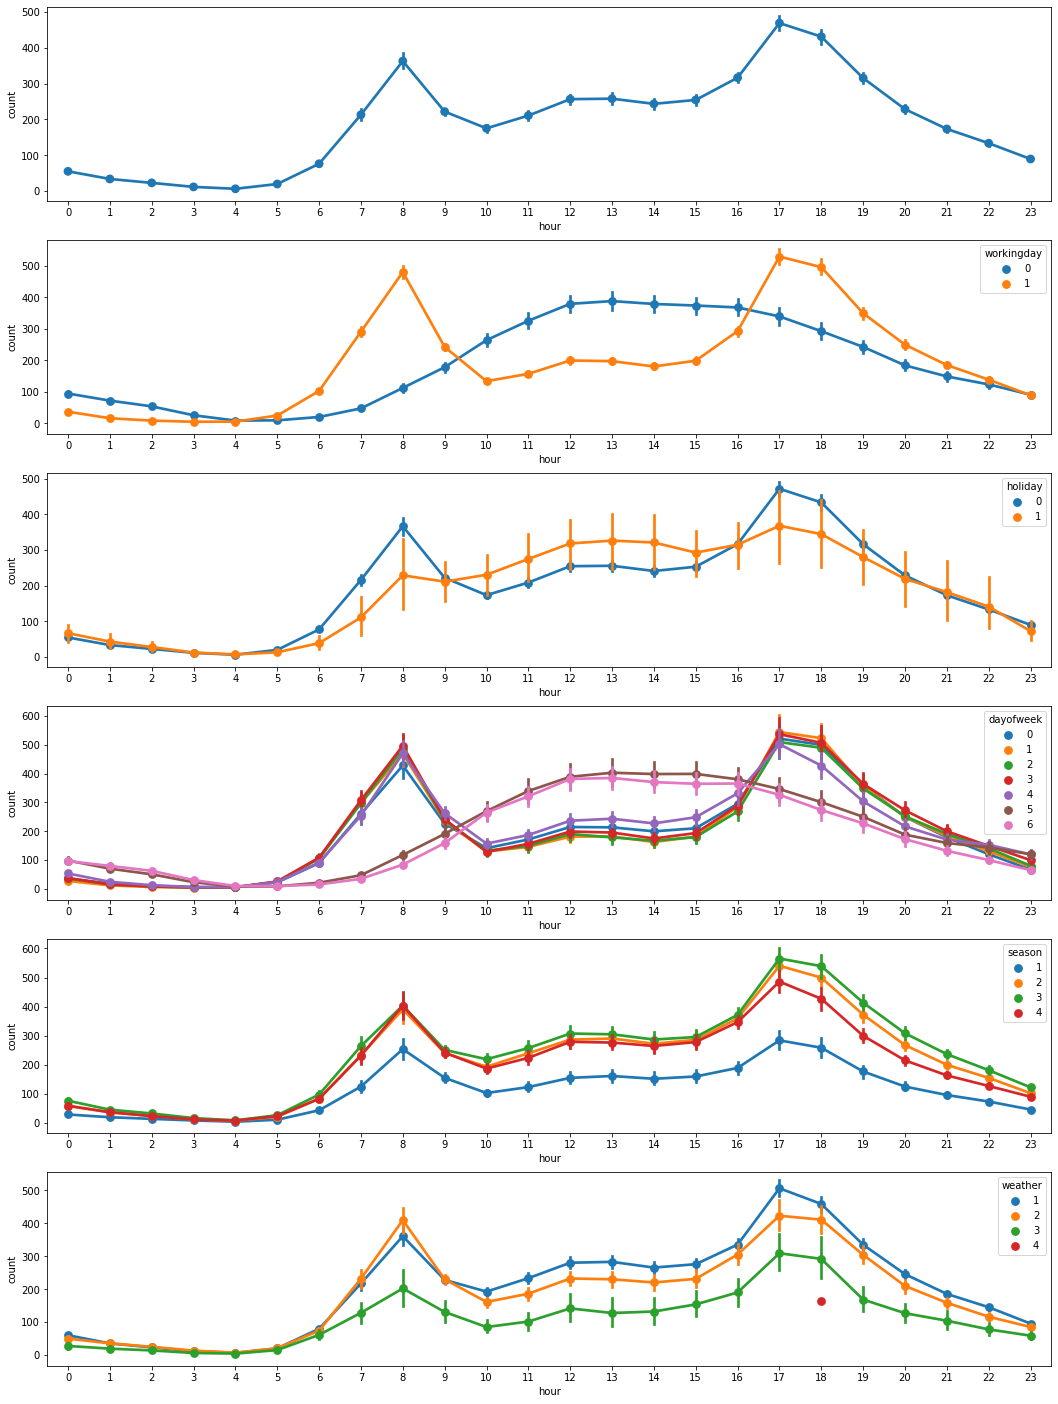

In [45]:
# hour별 대여량 다양하게 해서 그려보기
fig, axs = plt.subplots(6, 1, figsize = (18,25))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()

sns.pointplot(x = 'hour', y = 'count', data = train, ax = ax1)
sns.pointplot(x = 'hour', y = 'count', hue = 'workingday', data = train, ax = ax2)
sns.pointplot(x = 'hour', y = 'count', hue = 'holiday', data = train, ax = ax3)
sns.pointplot(x = 'hour', y = 'count', hue = 'dayofweek', data = train, ax = ax4)
sns.pointplot(x = 'hour', y = 'count', hue = 'season', data = train, ax = ax5)
sns.pointplot(x = 'hour', y = 'count', hue = 'weather', data = train, ax = ax6)

plt.show()

<해석>
앞에서도 살펴봤지만 요일별 데이터 수가 비슷하기 때문에 평일이 대다수를 이루고 있음.-> 그래프도 평일에 맞춰서 그려진다는 점!   
1. 첫번째 그래프: 그래서 평일과 비슷한 형태로 그려짐
2. workingday별로 나누어 그리면, 1이면 평일 / 0이면 주말, 공휴일처럼 그려짐
3. holiday별로 나누어 그리면 2번 그래프와 색깔이 반대로 나타난다
4. 요일로 나누어 그리면 그 경향이 더욱 두드러진다. **0~4(평일) 그래프와 5,6(주말) 그래프 양상 두드러짐**
5. 계절별로 보면 크게 달라지지 않음, 1분기 때 이용이 별로 없어서 낮게 나올뿐
6. 날씨별로 봐도 크게 두드러짐 없음  

근데 확실히 계절 2,3일때 날씨 1일때 이용이 많다

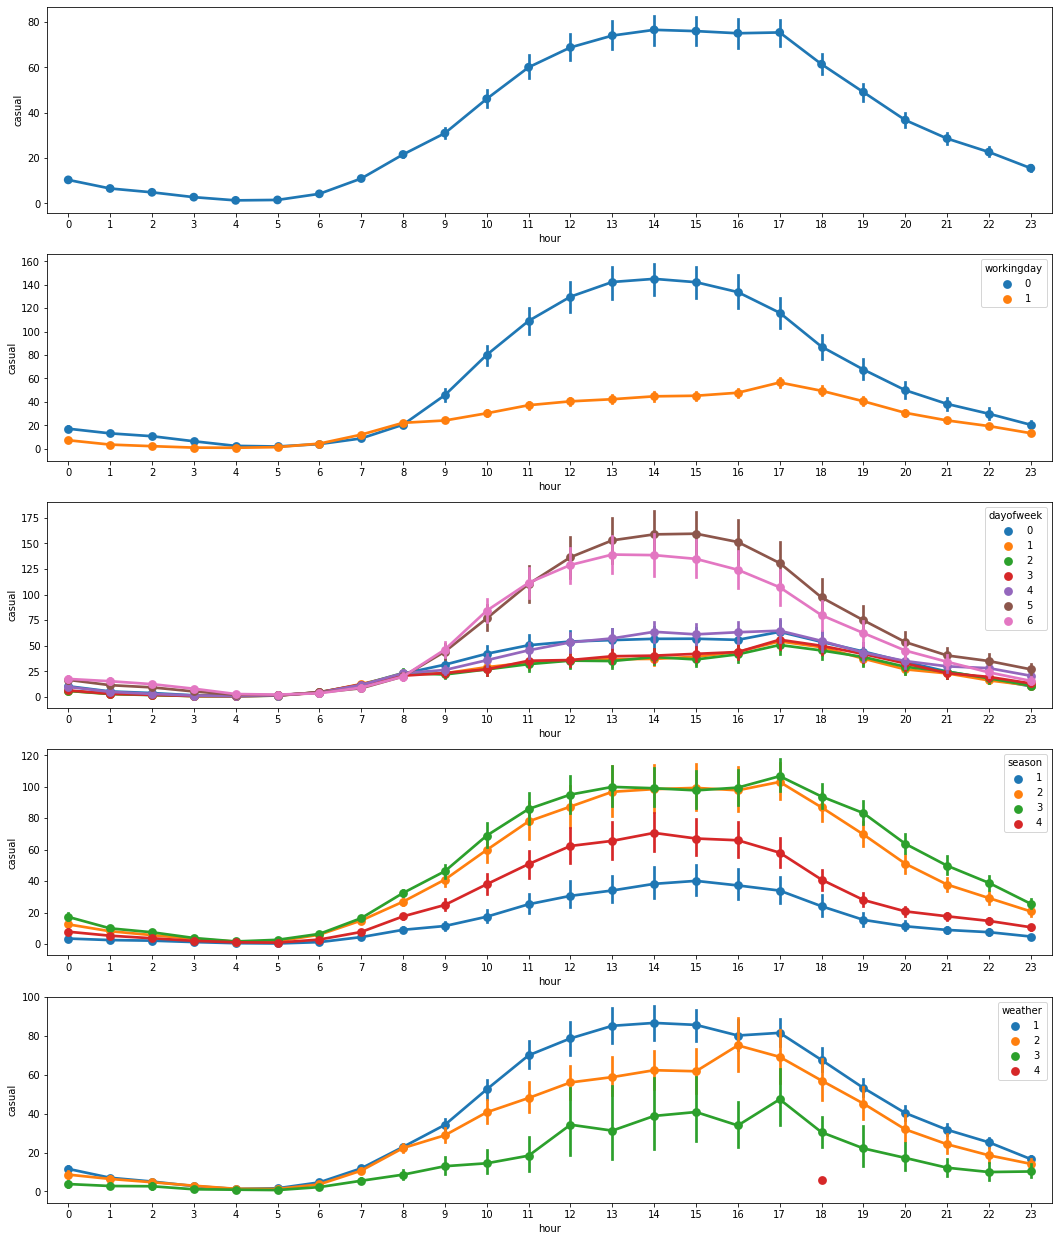

In [46]:
# hour별 casual 대여량 
fig, axs = plt.subplots(5, 1, figsize = (18,22))
ax1, ax2, ax3, ax4, ax5 = axs.flatten()

sns.pointplot(x = 'hour', y = 'casual', data = train, ax = ax1)
sns.pointplot(x = 'hour', y = 'casual', hue = 'workingday', data = train, ax = ax2)
sns.pointplot(x = 'hour', y = 'casual', hue = 'dayofweek', data = train, ax = ax3)
sns.pointplot(x = 'hour', y = 'casual', hue = 'season', data = train, ax = ax4)
sns.pointplot(x = 'hour', y = 'casual', hue = 'weather', data = train, ax = ax5)

plt.show()

<해석> **casual로 보면 전체 count로 봤을 때와 양상이 살짝 달라진다.(주말과 비슷한 분포를 보임)**  
1. 첫번째 그래프부터 hour별로 두드러지는게 보이지 않음. 즉석 대여를 하는 것이라 주로 낮 시간대 이용이 많다
2. 평일에는 즉석보단 registered를 많이 이용하기 때문에 평일의 경우 hour가 두드러지지 않는다.
3. 요일도 평일 / 주말 나눠서 두드러지게 나타난다
4. 분기별로 그래프 양상이 달라지지 않음
5. 날씨별로 그래프 양상이 달라지지 않음   

하지만 이번에도 역시 분기가 2,3일 때 & 날씨가 1일 때 이용이 많아진다는 것!!

### 2) hour별 평균 대여량과 연속형 변수들 이중축 만들기

#### 1. 온도(temp, atemp)

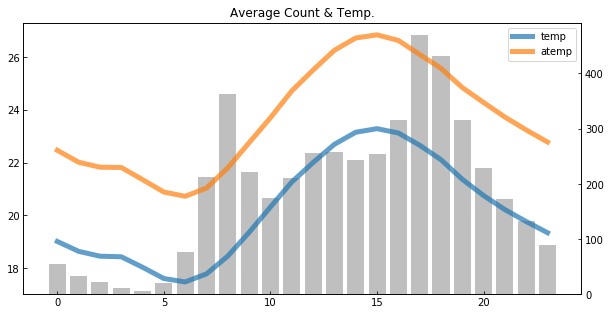

In [47]:
hourtemp_mean = train.groupby(by = 'hour')[['temp', 'atemp']].mean()

# (시간대별) 평균기온과 이용량의 차이
newdf = train.groupby('hour')[['count']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(hourtemp_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(hourtemp_mean.columns)

ax2 = ax1.twinx()
ax2.bar('hour', 'count', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Count & Temp.')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

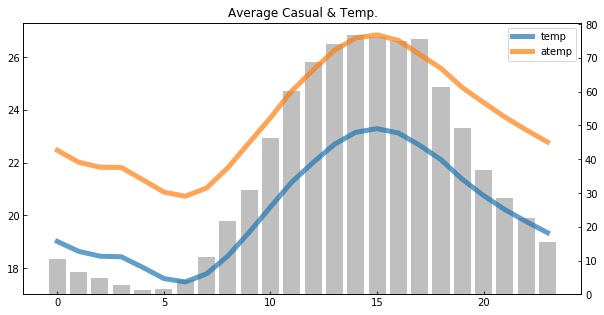

In [48]:
# (시간대별) 평균기온과 casual 차이
newdf = train.groupby('hour')[['casual']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(hourtemp_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(hourtemp_mean.columns)

ax2 = ax1.twinx()
ax2.bar('hour', 'casual', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Casual & Temp.')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

**시간대별 그래프**를 보면 평균대여량-평균온도 간엔 큰 관계가 있다.    
정비례하는 관계로, 온도가 높아지면 이용량 증가, 온도가 낮아지면 이용량은 감소함. 특히 `Casual`에서.

#### 2. 습도(humidity)

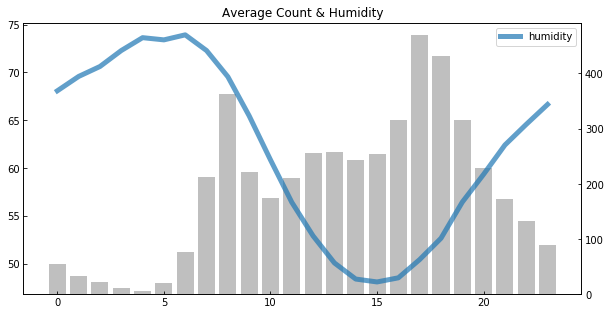

In [49]:
humidtemp_mean = train.groupby(by = 'hour')[['humidity']].mean()

# (시간대별) 평균습도와 이용량의 차이
newdf = train.groupby('hour')[['count']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(humidtemp_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(humidtemp_mean.columns)

ax2 = ax1.twinx()
ax2.bar('hour', 'count', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Count & Humidity')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

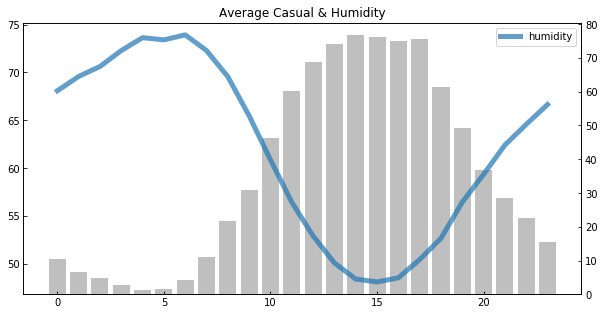

In [50]:
humidtemp_mean = train.groupby(by = 'hour')[['humidity']].mean()

# (시간대별) 평균습도와 이용량의 차이
newdf = train.groupby('hour')[['casual']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(humidtemp_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(humidtemp_mean.columns)

ax2 = ax1.twinx()
ax2.bar('hour', 'casual', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Casual & Humidity')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

**시간대별 그래프**를 보면 평균대여량-평균습도 간에도 관계가 꽤 잘 나타난다.   
반비례하는 관계로,습도가 높아지면 이용량 감소함. 특히 `Casual`에서.

#### 3. 풍향(windspeed)

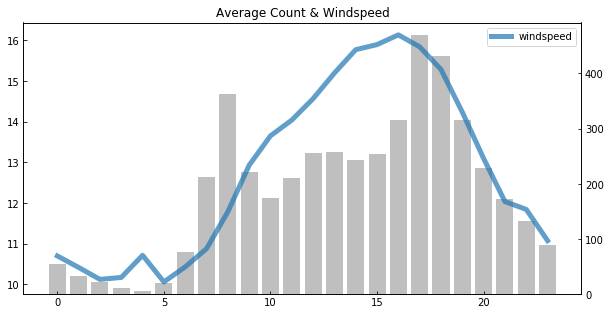

In [51]:
ws_mean = train.groupby(by = 'hour')[['windspeed']].mean()

# (시간대별) 평균습도와 이용량의 차이
newdf = train.groupby('hour')[['count']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(ws_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(ws_mean.columns)

ax2 = ax1.twinx()
ax2.bar('hour', 'count', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Count & Windspeed')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

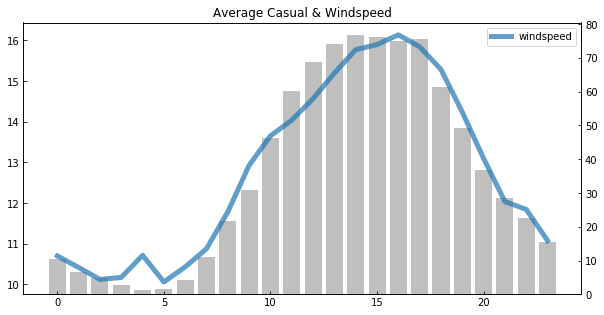

In [52]:
ws_mean = train.groupby(by = 'hour')[['windspeed']].mean()

# (시간대별) 평균습도와 이용량의 차이
newdf = train.groupby('hour')[['casual']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(ws_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(ws_mean.columns)

ax2 = ax1.twinx()
ax2.bar('hour', 'casual', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Casual & Windspeed')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

마찬가지로 **windspeed에 대해서도 시간대별로 정비례하는 경향**을 보인다. 특히 `Casual`에서.

### 3) month별 평균 대여량

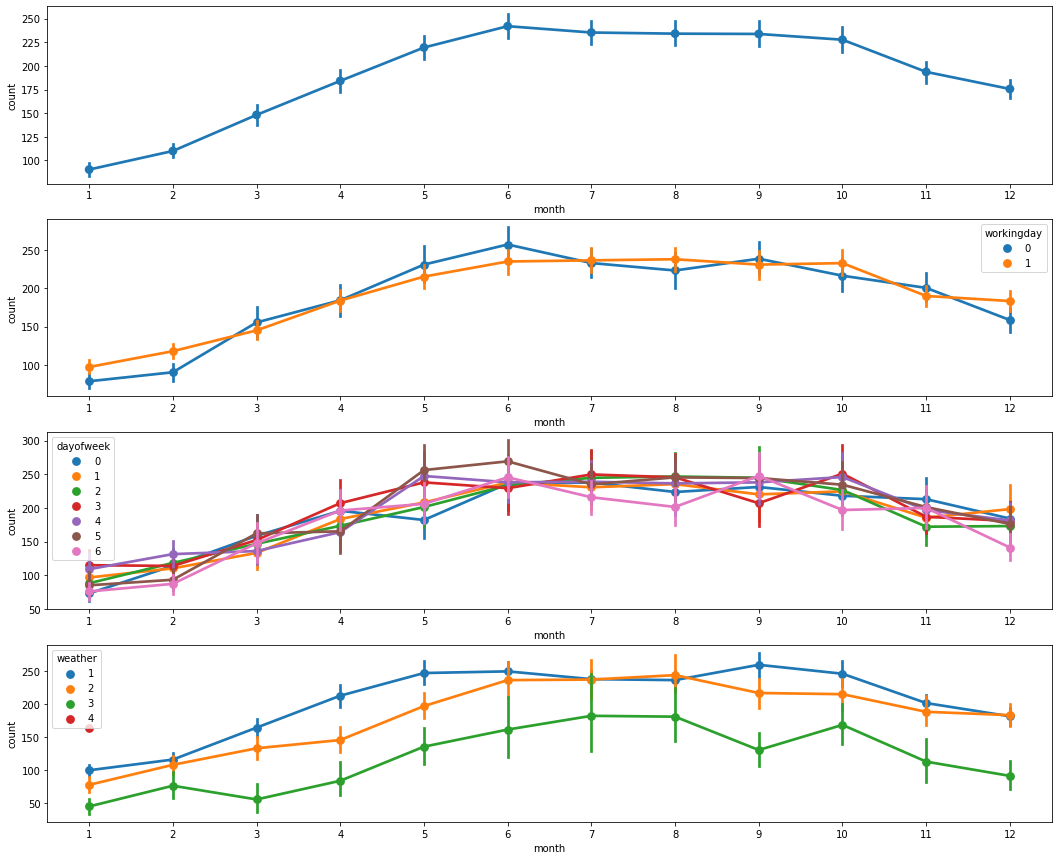

In [53]:
# month별 대여량 다양하게 해서 그려보기
fig, axs = plt.subplots(4, 1, figsize = (18,15))
ax1, ax2, ax3, ax4 = axs.flatten()

sns.pointplot(x = 'month', y = 'count', data = train, ax = ax1)
sns.pointplot(x = 'month', y = 'count', hue = 'workingday', data = train, ax = ax2)
sns.pointplot(x = 'month', y = 'count', hue = 'dayofweek', data = train, ax = ax3)
sns.pointplot(x = 'month', y = 'count', hue = 'weather', data = train, ax = ax4)

plt.show()

<해석>  
1. month별 대여량 - **5월부터 10월까지 대여량 많음**
2. month별로는 딱히 평일/주말을 나눠서 볼필요가 없을듯. 월별로는 평일이든 주말이든 차이 없음
3. 위와 동일
4. 날씨별로 다른 양상이 나타나지 않음. 역시 날씨가 1일수록 대여량 많음

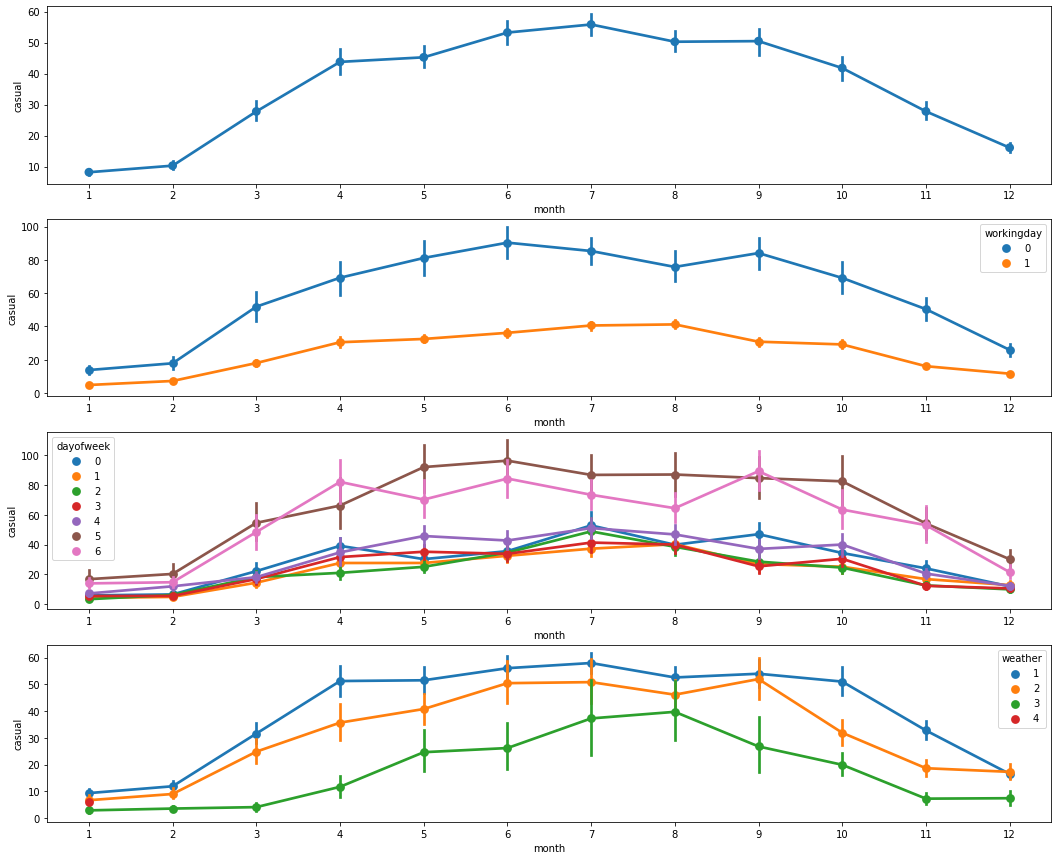

In [54]:
# month별 대여량 다양하게 해서 그려보기
fig, axs = plt.subplots(4, 1, figsize = (18,15))
ax1, ax2, ax3, ax4 = axs.flatten()

sns.pointplot(x = 'month', y = 'casual', data = train, ax = ax1)
sns.pointplot(x = 'month', y = 'casual', hue = 'workingday', data = train, ax = ax2)
sns.pointplot(x = 'month', y = 'casual', hue = 'dayofweek', data = train, ax = ax3)
sns.pointplot(x = 'month', y = 'casual', hue = 'weather', data = train, ax = ax4)

plt.show()

<해석>  
casual로 보면 당연하게도 평일/주말이 확연하게 나뉜다. (주말에 즉석대여가 더 많기 때문)  
1. 첫번째 그래프: casual 이용은 4월~9월 많음
2. 두번쨰 그래프: 주말과 공휴일 casual 이용은 5,6,7월 많다
3. 4번째 그래프: 날씨별 양상이 다르지 않음, 역시 날씨 1일때 대여량 가장 많음

### 4) month별 평균 대여량과 연속형 변수들 이중축 만들기
#### 1. 온도(temp, atemp)

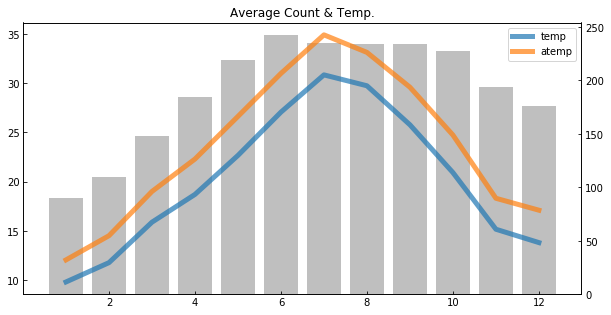

In [55]:
# (월별) 평균기온과 이용량의 차이
temp_mean = train.groupby(by = 'month')[['temp', 'atemp']].mean()
newdf = train.groupby('month')[['count']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(temp_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(temp_mean.columns)

ax2 = ax1.twinx()
ax2.bar('month', 'count', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Count & Temp.')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

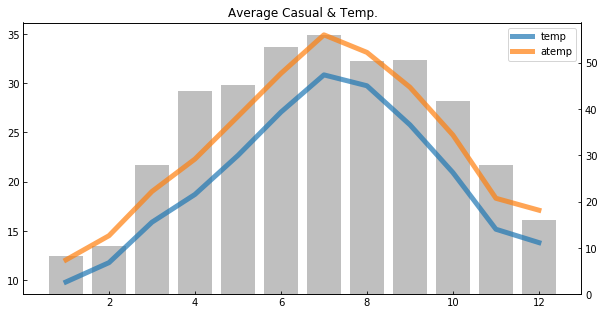

In [56]:
# (월별) 평균기온과 이용량(casual: 예약안함)의 차이
newdf2 = train.groupby('month')[['casual']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(temp_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(temp_mean.columns)

ax2 = ax1.twinx()
ax2.bar('month', 'casual', data=newdf2, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Casual & Temp.')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

**월별 이용량은 온도에 있어 큰 상관성을 보임.**  
특히 `casual`일 때 더욱, 온도가 높으면 대여량이 많고 낮으면 대여량이 적은 정비례 관계   

#### 2. 습도(humidity)

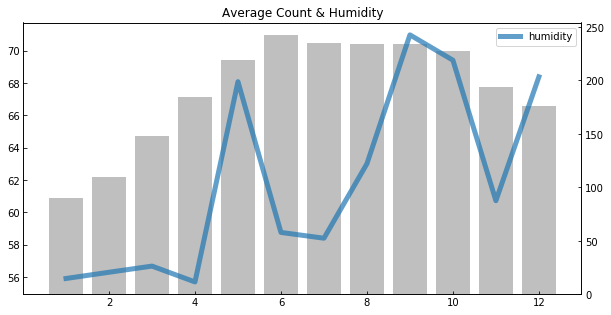

In [57]:
humid_mean = train.groupby(by = 'month')[['humidity']].mean()
newdf = train.groupby('month')[['count']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(humid_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(humid_mean.columns)

ax2 = ax1.twinx()
ax2.bar('month', 'count', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Count & Humidity')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

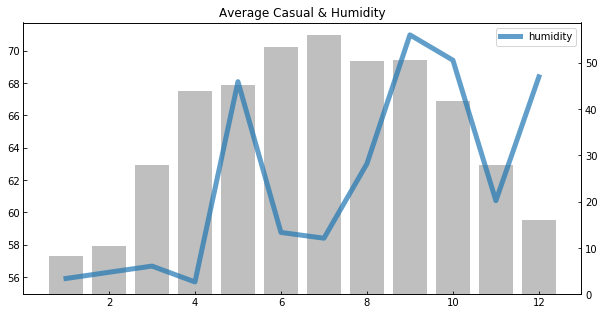

In [58]:
humid_mean = train.groupby(by = 'month')[['humidity']].mean()
newdf = train.groupby('month')[['casual']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(humid_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(humid_mean.columns)

ax2 = ax1.twinx()
ax2.bar('month', 'casual', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Casual & Humidity')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

**월별로 나눠봤을 때 습도와 이용량은 큰 연관성이 없었다.**

#### 3. 풍향(windspeed)

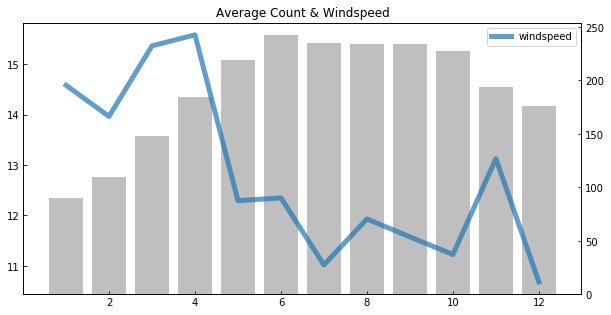

In [59]:
ws_mean = train.groupby(by = 'month')[['windspeed']].mean()
newdf = train.groupby('month')[['count']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(ws_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(ws_mean.columns)

ax2 = ax1.twinx()
ax2.bar('month', 'count', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Count & Windspeed')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

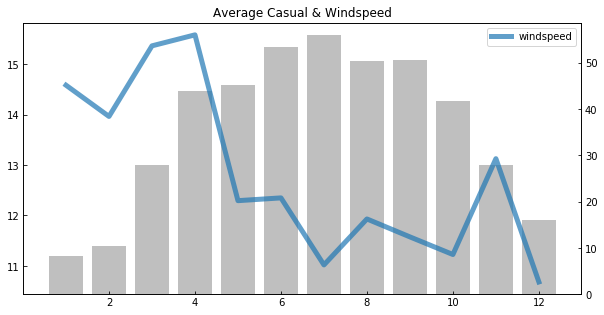

In [60]:
ws_mean = train.groupby(by = 'month')[['windspeed']].mean()
newdf = train.groupby('month')[['casual']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.plot(ws_mean, linewidth=5, alpha=0.7)
ax1.tick_params(axis='both', direction='in')
ax1.legend(ws_mean.columns)

ax2 = ax1.twinx()
ax2.bar('month', 'casual', data=newdf, color = 'gray', alpha = 0.5)
ax2.tick_params(axis='y', direction='in')
ax2.set_title('Average Casual & Windspeed')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

마찬가지로 풍향도 **월별로 나눠봤을 때 어떠한 경향성도 찾을 수 없었다.**